<a href="https://colab.research.google.com/github/emuduko/0760902445/blob/main/diffused_knowledge_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import files
uploaded = files.upload()

Saving uganda_farming_dataset.csv to uganda_farming_dataset (1).csv


In [3]:
df = pd.read_csv("uganda_farming_dataset.csv")
df.head()

,Region,Soil_pH,Nitrogen,Phosphorus,Potassium,Rainfall,Temperature,Humidity,Crop_Type,Leaf_Chlorophyll,Pest_Infestation,Recommended_Fertilizer
0,Eastern Uganda,5.81,0.57,30.6,187.6,618.4,20.7,43.2,Cassava,45.3,0.60,Urea
1,Eastern Uganda,6.98,0.06,38.9,253.1,697.3,21.1,50.1,Groundnuts,25.6,0.52,Urea or NPK 17-17-17
2,Central Uganda,6.01,0.21,26.4,59.1,809.0,24.2,65.1,Banana,42.5,0.20,DAP
3,Bugisu,6.30,0.38,6.6,190.1,638.7,19.1,92.2,Maize,48.8,0.81,DAP or NPK 17-17-17
4,Eastern Uganda,5.57,0.10,28.9,143.2,570.9,26.4,41.9,Sorghum,46.8,0.26,Urea or NPK 17-17-17


In [4]:
!pip install pandas numpy matplotlib scikit-learn networkx torch torch-geometric


In [5]:
#Remove duplicates
df.drop_duplicates(inplace = True)

In [6]:
#Trim whitespace and standardize text case
for col in ['Region', 'Crop_Type', 'Recommended_Fertilizer']:
    df[col] = df[col].astype(str).str.strip().str.title()

In [7]:
for col in df.columns:
    if df[col].dtype in [np.float64, np.int64]:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])


In [8]:
#detect and handle outliers (using z-score filtering)
from scipy import stats
numeric_cols = df.select_dtypes(include=[np.number]).columns
z_scores = np.abs(stats.zscore(df[numeric_cols]))
df = df[(z_scores < 3).all(axis=1)]  # keep only rows within 3 standard deviations

print("Data Cleaning & Harmonization Done")
print(df.head())

Data Cleaning & Harmonization Done
           Region  Soil_pH  Nitrogen  Phosphorus  Potassium  Rainfall  \
0  Eastern Uganda     5.81      0.57        30.6      187.6     618.4   
1  Eastern Uganda     6.98      0.06        38.9      253.1     697.3   
2  Central Uganda     6.01      0.21        26.4       59.1     809.0   
3          Bugisu     6.30      0.38         6.6      190.1     638.7   
4  Eastern Uganda     5.57      0.10        28.9      143.2     570.9   

   Temperature  Humidity   Crop_Type  Leaf_Chlorophyll  Pest_Infestation  \
0         20.7      43.2     Cassava              45.3              0.60   
1         21.1      50.1  Groundnuts              25.6              0.52   
2         24.2      65.1      Banana              42.5              0.20   
3         19.1      92.2       Maize              48.8              0.81   
4         26.4      41.9     Sorghum              46.8              0.26   

  Recommended_Fertilizer  
0                   Urea  
1   Urea Or Npk

In [9]:
#FEATURE PREPARATION FOR KNOWLEDGE GRAPH

#create unique IDs for categorical entities
df['Region_ID'] = df['Region'].astype('category').cat.codes
df['Crop_ID'] = df['Crop_Type'].astype('category').cat.codes
df['Fert_ID'] = df['Recommended_Fertilizer'].astype('category').cat.codes

#define entities
soil_features = ['Soil_pH','Nitrogen','Phosphorus','Potassium']
env_features = ['Rainfall','Temperature','Humidity']
crop_features = ['Leaf_Chlorophyll','Pest_Infestation']

#prepare node tables
regions = df[['Region_ID','Region']].drop_duplicates()
crops = df[['Crop_ID', 'Crop_Type']].drop_duplicates()
fertilizers = df[['Fert_ID', 'Recommended_Fertilizer']].drop_duplicates()
soils = df[soil_features]
envs = df[env_features]

#Generate relations (edges)
edges = []
for _, row in df.iterrows():
    edges += [
        ('Region_' + str(row['Region_ID']), 'Soil_' + str(_), 'has'),
        ('Region_' + str(row['Region_ID']), 'Env_' + str(_), 'experiences'),
        ('Soil_' + str(_), 'Crop_' + str(row['Crop_ID']), 'affects'),
        ('Env_' + str(_), 'Crop_' + str(row['Crop_ID']), 'influences'),
        ('Crop_' + str(row['Crop_ID']), 'Fert_' + str(row['Fert_ID']), 'requires')
    ]

edges_df = pd.DataFrame(edges, columns=['Source', 'Target', 'Relation'])

print("Entity and Relationship Tables Ready")
print("Entities: Region, Crop, Fertilizer, Soil, Environment")
print(edges_df.head())

Entity and Relationship Tables Ready
Entities: Region, Crop, Fertilizer, Soil, Environment
     Source   Target     Relation
0  Region_3   Soil_0          has
1  Region_3    Env_0  experiences
2    Soil_0   Crop_2      affects
3     Env_0   Crop_2   influences
4    Crop_2  Fert_12     requires


In [10]:
#NUMERICAL SCALING & ENCODING

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import joblib

#Encode categorical features
label_encoders = {}
for col in ['Region', 'Crop_Type', 'Recommended_Fertilizer']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

#Normalize numeric features
scaler = MinMaxScaler()
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = scaler.fit_transform(df[num_cols])

#Save encoders and scalers (for reuse during deployment)
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(scaler, 'scaler.pkl')

#Export preprocessed dataset
df.to_csv('encoded_df.csv', index=False)

print("Encoding & Scaling Completed. File saved as encoded_df.csv")
df.head()


Encoding & Scaling Completed. File saved as encoded_df.csv


,Region,Soil_pH,Nitrogen,Phosphorus,Potassium,Rainfall,Temperature,Humidity,Crop_Type,Leaf_Chlorophyll,Pest_Infestation,Recommended_Fertilizer,Region_ID,Crop_ID,Fert_ID
0,0.500000,0.374286,0.945455,0.733524,0.598999,0.156067,0.158824,0.058182,0.4,0.868195,0.60,0.923077,0.500000,0.4,0.923077
1,0.500000,0.708571,0.018182,0.971347,0.833095,0.212448,0.182353,0.183636,0.6,0.303725,0.52,1.000000,0.500000,0.6,1.000000
2,0.333333,0.431429,0.290909,0.613181,0.139743,0.292268,0.364706,0.456364,0.0,0.787966,0.20,0.153846,0.333333,0.0,0.153846
3,0.000000,0.514286,0.600000,0.045845,0.607934,0.170573,0.064706,0.949091,0.8,0.968481,0.81,0.230769,0.000000,0.8,0.230769
4,0.500000,0.305714,0.090909,0.684814,0.440315,0.122124,0.494118,0.034545,1.0,0.911175,0.26,1.000000,0.500000,1.0,1.000000


Graph built with 2006 nodes and 4004 edges.


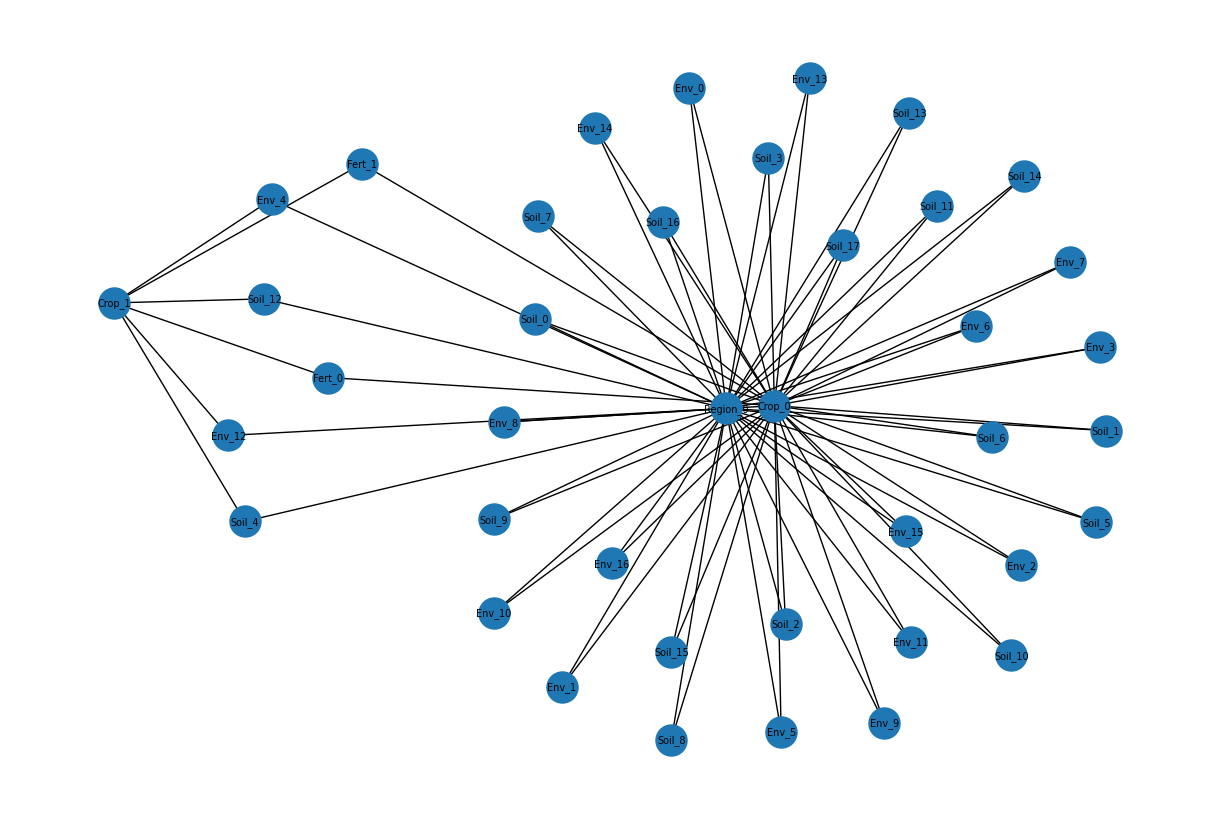

In [11]:
# STEP 1. GRAPH CONSTRUCTION (NetworkX)

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Load encoded data
df = pd.read_csv("encoded_df.csv")

# Build an undirected Knowledge Graph
G = nx.Graph()

# Add nodes with attributes
for _, row in df.iterrows():
    # Create node names
    region = f"Region_{int(row['Region'])}"
    crop = f"Crop_{int(row['Crop_Type'])}"
    fert = f"Fert_{int(row['Recommended_Fertilizer'])}"
    soil = f"Soil_{_}"
    env = f"Env_{_}"

    # Add nodes with features
    G.add_node(region, type="Region")
    G.add_node(crop, type="Crop")
    G.add_node(fert, type="Fertilizer")
    G.add_node(soil, type="Soil", pH=row['Soil_pH'], N=row['Nitrogen'], P=row['Phosphorus'], K=row['Potassium'])
    G.add_node(env, type="Environment", Rainfall=row['Rainfall'], Temperature=row['Temperature'], Humidity=row['Humidity'])

    # Add relationships (edges)
    G.add_edges_from([
        (region, soil, {'relation': 'has'}),
        (region, env, {'relation': 'experiences'}),
        (soil, crop, {'relation': 'affects'}),
        (env, crop, {'relation': 'influences'}),
        (crop, fert, {'relation': 'requires'})
    ])

print(f"Graph built with {len(G.nodes())} nodes and {len(G.edges())} edges.")

# Visualize small subgraph (optional)
subset = list(G.nodes)[:40]
H = G.subgraph(subset)
plt.figure(figsize=(12, 8))
nx.draw(H, with_labels=True, node_size=500, font_size=7)
plt.show()


In [12]:
!pip install node2vec


In [ ]:
#DIFFUSION EMBEDDING (Node2Vec)
from node2vec import Node2Vec

# Train Node2Vec on the graph
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get embedding for any node
print(model.wv['Crop_1'])

# Save embeddings
model.wv.save_word2vec_format("graph_embeddings.txt")

print("Diffusion embeddings learned and saved.")


Computing transition probabilities:   0%|          | 0/2006 [00:00<?, ?it/s]